## Try some bond dissociations of PFAS molecules

## Perflourooctanoic Acid (PFOA) 

Find the dissociation curve and resource requirements

## Visualisation

In [1]:
"""Tools to plot molecular orbitals."""

import logging
import os
from typing import List

import numpy as np
import py3Dmol
from pyscf import gto
from pyscf.tools import cubegen

logger = logging.getLogger(__name__)


def Draw_molecule(
    xyz_string: str, width: int = 400, height: int = 400, style: str = "sphere"
) -> py3Dmol.view:
    """Draw molecule from xyz string.

    Note if molecule has unrealistic bonds, then style should be sphere. Otherwise stick style can be used
    which shows bonds.

    TODO: more styles at http://3dmol.csb.pitt.edu/doc/$3Dmol.GLViewer.html

    Args:
        xyz_string (str): xyz string of molecule
        width (int): width of image
        height (int): Height of image
        style (str): py3Dmol style ('sphere' or 'stick')

    Returns:
        view (py3dmol.view object). Run view.show() method to print molecule.
    """
    logger.debug("Drawing molecule.")
    if style == "sphere":
        view = py3Dmol.view(
            data=xyz_string,
            style={"sphere": {"radius": 0.2}},
            width=width,
            height=height,
        )
    elif style == "stick":
        view = py3Dmol.view(
            data=xyz_string, style={"stick": {}}, width=width, height=height
        )
    elif style == "line":
        view = py3Dmol.view(
            data=xyz_string, style={"line":{"linewidth":16}}, width=width, height=height
        )
    else:
        raise ValueError(f"unknown py3dmol style: {style}")

    view.zoomTo()
    return view


def draw_cube_orbital(
    PySCF_mol_obj: gto.Mole,
    xyz_string: str,
    C_matrix: np.ndarray,
    index_list: List[int],
    width: int = 400,
    height: int = 400,
    style: str = "sphere",
) -> List:
    """Draw orbials given a C_matrix and xyz string of molecule.

    This function writes orbitals to tempory cube files then deletes them.
    For standard use the C_matrix input should be C_matrix optimized by a self consistent field (SCF) run.
    Note if molecule has unrealistic bonds, then style should be set to sphere.

    Args:
        PySCF_mol_obj (pyscf.mol): PySCF mol object. Required for pyscf.tools.cubegen function
        xyz_string (str): xyz string of molecule
        C_matrix (np.array): Numpy array of molecular orbitals (columns are MO).
        index_list (List): List of MO indices to plot
        width (int): width of image
        height (int): Height of image
        style (str): py3Dmol style ('sphere' or 'stick')

    Returns:
        plotted_orbitals (List): List of plotted orbitals (py3Dmol.view) ordered the same way as in index_list
    """
    logger.debug("Drawing cube orbital.")
    if not set(index_list).issubset(set(range(C_matrix.shape[1]))):
        raise ValueError(
            "list of MO indices to plot is outside of C_matrix column indices"
        )

    plotted_orbitals = []
    for index in index_list:
        File_name = f"temp_MO_orbital_index{index}.cube"
        cubegen.orbital(PySCF_mol_obj, File_name, C_matrix[:, index])

        view = py3Dmol.view(width=width, height=height)
        view.addModel(xyz_string, "xyz")
        if style == "sphere":
            view.setStyle({"sphere": {"radius": 0.2}})
        elif style == "stick":
            view.setStyle({"stick": {}})
        else:
            raise ValueError(f"unknown py3dmol style: {style}")

        with open(File_name, "r") as f:
            view.addVolumetricData(
                f.read(), "cube", {"isoval": -0.02, "color": "red", "opacity": 0.75}
            )
        with open(File_name, "r") as f2:
            view.addVolumetricData(
                f2.read(), "cube", {"isoval": 0.02, "color": "blue", "opacity": 0.75}
            )

        plotted_orbitals.append(view.zoomTo())
        os.remove(File_name)  # delete file once orbital is drawn

    return plotted_orbitals

## Generate Geometries

In [2]:
import pandas as pd
import numpy as np
from nbed.utils import pubchem_mol_geometry, build_ordered_xyz_string, save_ordered_xyz_file

def init_mol_df(mol_name: str, f_index: int = None, c_index: int = None) -> pd.DataFrame:
    mol_geometry = pubchem_mol_geometry(mol_name)
    save_ordered_xyz_file("pfba", mol_geometry, active_atom_inds=[f_index, c_index])
    print(mol_geometry)

    if f_index is None or c_index is None:
        f_index = input("Enter the index of the fluorine atom: ")
        f_index = int(f_index)
        c_index = input("Enter the index of the carbon atom: ")
        c_index = int(c_index)

    start_f = np.array(mol_geometry[f_index][1])
    start_c = np.array(mol_geometry[c_index][1])
    displacement = start_f - start_c

    positions = [start_c + i *displacement for i in np.linspace(0.5,2.5,25)]
    distances = [np.linalg.norm(i) for i in positions]
    df = pd.DataFrame(index = range(len(distances)), columns = ["distances", "positions", "xyz"])
    df["distances"] = distances
    df["positions"] = positions

    xyz_list = []

    for i, p in enumerate(positions):
        mol_geometry[f_index] = (mol_geometry[f_index][0], (p[0], p[1], p[2]))
        xyz_list.append(build_ordered_xyz_string(mol_geometry, active_atom_inds=[f_index,c_index]))

    df["xyz"] = xyz_list
    return df

pfbs = init_mol_df("perfluorobutanesulfonate", 4,14)

{0: ('S', (-2.1366, -0.7035, -0.3567)), 1: ('F', (-0.4707, 1.8316, -1.0186)), 2: ('F', (0.5998, 1.8991, 0.8687)), 3: ('F', (-0.6143, -0.3985, 1.7062)), 4: ('F', (-1.8799, 1.2957, 1.2314)), 5: ('F', (0.7124, -0.5316, -1.6698)), 6: ('F', (2.0552, 1.1097, -1.2101)), 7: ('F', (1.1709, -1.5602, 0.8975)), 8: ('F', (2.9607, -1.3092, -0.3238)), 9: ('F', (2.5293, 0.1037, 1.2716)), 10: ('O', (-1.2198, -1.7018, -0.9017)), 11: ('O', (-3.14, -1.2223, 0.5693)), 12: ('O', (-2.6583, 0.2437, -1.341)), 13: ('C', (0.0474, 1.0383, -0.0381)), 14: ('C', (-1.1009, 0.3266, 0.6637)), 15: ('C', (1.1793, 0.2264, -0.6472)), 16: ('C', (1.9655, -0.6478, 0.2987))}


In [3]:
print(pfbs["xyz"][6])
tostretch = pfbs

17
 
F	-1.8799	1.2957	1.2314
C	-1.1009	0.3266	0.6637
S	-2.1366	-0.7035	-0.3567
F	-0.4707	1.8316	-1.0186
F	0.5998	1.8991	0.8687
F	-0.6143	-0.3985	1.7062
F	0.7124	-0.5316	-1.6698
F	2.0552	1.1097	-1.2101
F	1.1709	-1.5602	0.8975
F	2.9607	-1.3092	-0.3238
F	2.5293	0.1037	1.2716
O	-1.2198	-1.7018	-0.9017
O	-3.14	-1.2223	0.5693
O	-2.6583	0.2437	-1.341
C	0.0474	1.0383	-0.0381
C	1.1793	0.2264	-0.6472
C	1.9655	-0.6478	0.2987



In [4]:
Draw_molecule(tostretch["xyz"][5], style="sphere").show(), Draw_molecule(tostretch["xyz"][20], style="sphere").show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

(None, None)

## Find resource requirements

There are 89 Molecular Orbitals in the STO-3G basis.

This is significantly outside of the range which may be simulated directly on a quantum computer.

In [5]:
from pyscf.gto import Mole
from pathlib import Path
from pyscf.scf import RHF
from pyscf.dft import RKS
from pyscf.cc import CCSD
import pickle
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder

import numpy as np
import pandas as pd

def calculate_energies(df: pd.DataFrame, charge = 0, spin = 0, fci = False, ccsd = True) -> None:
        args = {"n_active_atoms": 2,
                "basis": "sto-3g",
                "xc_functional": "b3lyp",
                "projector": "huzinaga",
                "localization": "spade",
                "convergence": 1e-6,
                "max_ram_memory": 2_000_000,
                "run_fci_emb": fci,
                "run_ccsd_emb": ccsd,
                "charge": charge,
                "spin":spin,
                }
        df["mu_scf"] = pd.Series(dtype='object')
        df["huz_scf"] = pd.Series(dtype='object')
        for index, row in df.iterrows():
                try:
                        geom = row["xyz"]
                        print(f"Running geometry {geom}")
                        driver = NbedDriver(geometry=geom, **args)
                        # df.loc[index, "mu_nmo"] = driver.embedded_scf[0].mo_coeff.shape[-1]
                        df.loc[index, "huz_nmo"] = driver.embedded_scf.mo_coeff.shape[-1]

                        print("Running SCF Methods")
                        df.loc[index,"HF"] = driver._global_hf().e_tot
                        df.loc[index,"DFT"] = driver._global_ks().e_tot

                        print("Running Reference Methods")
                        if args["run_fci_emb"]:
                                print("Running FCI")
                                df.loc[index,"FCI"] = driver._global_fci().e_tot
                                # df.loc[index,"mu_FCI"] = driver._mu["e_fci"]
                                df.loc[index,"huz_FCI"] = driver._huzinaga["e_fci"]

                        if args["run_ccsd_emb"]:
                                df.loc[index,"CCSD"] = driver._global_ccsd().e_tot
                                # df.loc[index,"mu_CCSD"] = driver._mu["e_ccsd"]
                                df.loc[index,"huz_CCSD"] = driver._huzinaga["e_ccsd"]
                        
                        # df.loc[index,"mu_classical"] = driver._mu["classical_energy"]
                        df.loc[index,"huz_classical"] = driver._huzinaga["classical_energy"]

                        # df.loc[index, "mu_scf"] = driver.embedded_scf[0]
                        # df.loc[index, "huz_scf"] = driver.embedded_scf[1]

                        # muham = HamiltonianBuilder(driver.embedded_scf[0], driver.classical_energy[0]).build(taper=True)
                        # huzham = HamiltonianBuilder(driver.embedded_scf[1], driver.classical_energy[1]).build(taper=True)
                        # with open(f"fluoromethane_huzham_{geom}.pkl", "wb") as f:
                        #         pickle.dump(huzham, f)

                        
                except np.linalg.linalg.LinAlgError:
                        print(f"Geometry {geom} failed")

                with open(f"fluoromethane_{index}.pkl", "wb") as f:
                        pickle.dump(df, f)


In [ ]:
calculate_energies(tostretch, spin=0, charge=1)
tostretch.head()

Running geometry 17
 
F	-1.4904	0.81115	0.94755
C	-1.1009	0.3266	0.6637
S	-2.1366	-0.7035	-0.3567
F	-0.4707	1.8316	-1.0186
F	0.5998	1.8991	0.8687
F	-0.6143	-0.3985	1.7062
F	0.7124	-0.5316	-1.6698
F	2.0552	1.1097	-1.2101
F	1.1709	-1.5602	0.8975
F	2.9607	-1.3092	-0.3238
F	2.5293	0.1037	1.2716
O	-1.2198	-1.7018	-0.9017
O	-3.14	-1.2223	0.5693
O	-2.6583	0.2437	-1.341
C	0.0474	1.0383	-0.0381
C	1.1793	0.2264	-0.6472
C	1.9655	-0.6478	0.2987



/Users/michaelwilliamsdelabastida/Library/Caches/pypoetry/virtualenvs/nbed-1_9TTDE1-py3.10/lib/python3.10/site-packages/pyscf/dft/libxc.py:507: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
Initialize <pyscf.gto.mole.Mole object at 0x1067f5b40> in <pyscf.dft.rks.RKS object at 0x1067f58d0>


driver.embedded_scf.mo_coeff.shape=(2,)
driver.embedded_scf.mo_occ=array([array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0.])                               ,
       array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0.])                               ],
      dtype=object)
driver.localized_system.shells=[19, 26]
Running SCF Methods
Running Reference Methods


In [ ]:
fluoromethane.loc[fluoromethane["DFT"] > -130, "DFT"] = np.nan

<Axes: title={'center': 'Fluoromethane Energy vs Distance'}, xlabel='Distance (Angstroms)', ylabel='Energy (Hartrees)'>

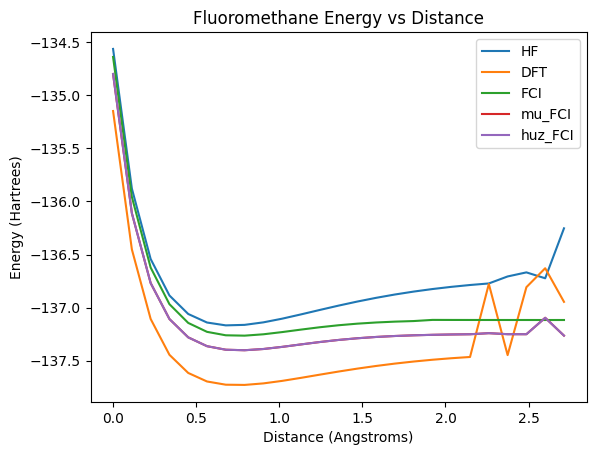

In [ ]:
fluoromethane[['distances','HF', 'DFT','FCI', 'mu_FCI', 'huz_FCI']].plot(xlabel="Distance (Angstroms)", ylabel="Energy (Hartrees)", x="distances", title="Fluoromethane Energy vs Distance")

## Graph differences in energy from FCI

PBE is obviously well suited to creating dissociation curves.

In [ ]:
f_diffs = fluoromethane[['HF','DFT']].subtract(fluoromethane["FCI"], axis=0)
f_diffs = pd.concat([f_diffs, fluoromethane.filter(regex=("_FCI")).subtract(fluoromethane["FCI"], axis=0)], axis=1)

<Axes: title={'center': 'Fluoromethane Energy Difference vs Distance'}, xlabel='distances'>

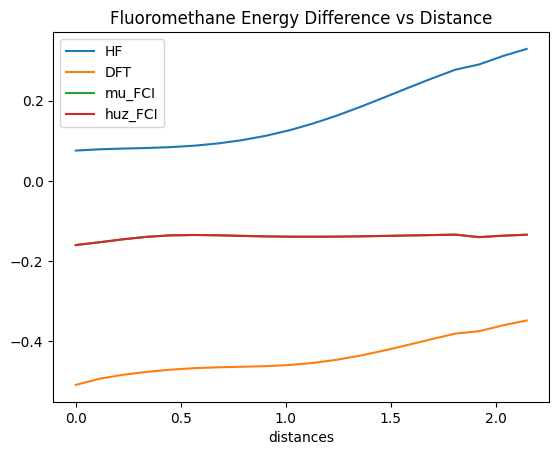

In [ ]:
f_diffs["distances"] = fluoromethane["distances"]
f_diffs[["distances","HF","DFT","mu_FCI","huz_FCI"]].loc[:19].plot(x="distances", title="Fluoromethane Energy Difference vs Distance")

With frozen core (no frozen virtuals yet)

<Axes: title={'center': 'Fluoromethane Energy Difference vs Distance'}>

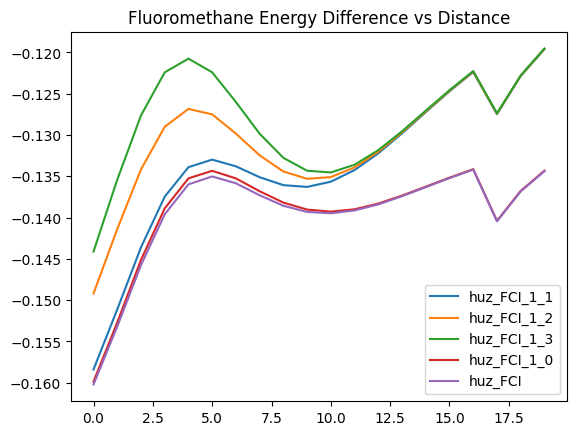

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
f_diffs.filter(regex=("huz_FCI_1_")).loc[:19].plot(title="Fluoromethane Energy Difference vs Distance", ax=ax, linestyle='-')
f_diffs[["huz_FCI"]].loc[:19].plot(ax=ax)
# f_diffs.filter(regex=("huz_FCI_2_")).loc[:19].plot(title="Fluoromethane Energy Difference vs Distance", ax=ax, linestyle='--')


<Axes: title={'center': 'Fluoromethane Energy Difference vs Distance'}>

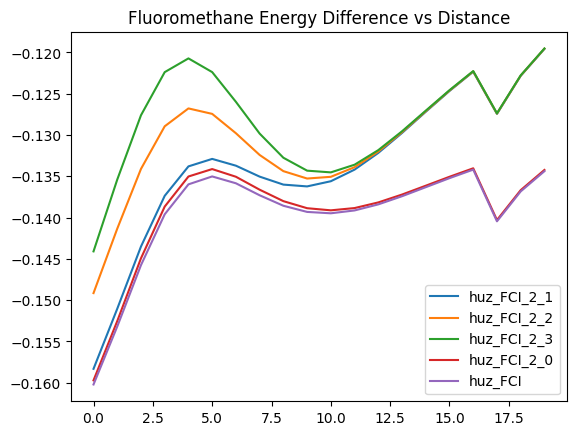

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
f_diffs.filter(regex=("huz_FCI_2_")).loc[:19].plot(title="Fluoromethane Energy Difference vs Distance", ax=ax, linestyle='-')
f_diffs[["huz_FCI"]].loc[:19].plot(ax=ax)

<Axes: title={'center': 'Fluoromethane Energy Difference vs Distance'}>

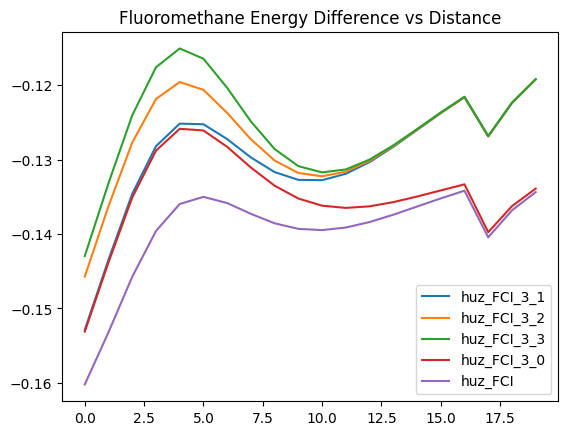

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
f_diffs.filter(regex=("huz_FCI_3_")).loc[:19].plot(title="Fluoromethane Energy Difference vs Distance", ax=ax, linestyle='-')
f_diffs[["huz_FCI"]].loc[:19].plot(ax=ax)

## PFOA

In [ ]:
pfoa = pubchem_mol_geometry("Perfluorooctanoic acid")
pfoa_ordered = build_ordered_xyz_string(pfoa, active_atom_inds=[11,22])
save_ordered_xyz_file("pfoa", pfoa, active_atom_inds=[11,22])
pfoa_df = init_mol_df("pfoa", 11, 22)

{0: ('F', (-1.0539, 1.9481, -0.2014)), 1: ('F', (0.5434, 1.2581, -1.5025)), 2: ('F', (1.2215, 1.6487, 1.0783)), 3: ('F', (-0.3328, 0.2934, 1.7581)), 4: ('F', (-1.8211, 0.1669, -2.1654)), 5: ('F', (-0.4525, -1.3197, -1.355)), 6: ('F', (2.0673, -0.7623, 1.9165)), 7: ('F', (0.8055, -1.7942, 0.487)), 8: ('F', (-2.9835, -1.7149, -0.6823)), 9: ('F', (-1.6932, -1.3046, 1.0212)), 10: ('F', (2.1054, -0.612, -1.6013)), 11: ('F', (3.3419, -1.7554, -0.2365)), 12: ('F', (-3.9677, 0.8422, -0.5956)), 13: ('F', (-2.6826, 1.3007, 1.1093)), 14: ('F', (-4.1728, -0.274, 1.2669)), 15: ('O', (4.5699, 0.3287, 0.6742)), 16: ('O', (3.3666, 1.6773, -0.7043)), 17: ('C', (-0.2911, 0.8598, -0.5112)), 18: ('C', (0.5314, 0.5262, 0.7274)), 19: ('C', (-1.2138, -0.2391, -1.0209)), 20: ('C', (1.5064, -0.6431, 0.6776)), 21: ('C', (-2.285, -0.7254, -0.0556)), 22: ('C', (2.6302, -0.5967, -0.3477)), 23: ('C', (-3.2786, 0.3, 0.4302)), 24: ('C', (3.5392, 0.5913, -0.1672)), 25: ('H', (5.1534, 1.1082, 0.793))}


In [ ]:
pfoa

{0: ('F', (-1.0539, 1.9481, -0.2014)),
 1: ('F', (0.5434, 1.2581, -1.5025)),
 2: ('F', (1.2215, 1.6487, 1.0783)),
 3: ('F', (-0.3328, 0.2934, 1.7581)),
 4: ('F', (-1.8211, 0.1669, -2.1654)),
 5: ('F', (-0.4525, -1.3197, -1.355)),
 6: ('F', (2.0673, -0.7623, 1.9165)),
 7: ('F', (0.8055, -1.7942, 0.487)),
 8: ('F', (-2.9835, -1.7149, -0.6823)),
 9: ('F', (-1.6932, -1.3046, 1.0212)),
 10: ('F', (2.1054, -0.612, -1.6013)),
 11: ('F', (3.3419, -1.7554, -0.2365)),
 12: ('F', (-3.9677, 0.8422, -0.5956)),
 13: ('F', (-2.6826, 1.3007, 1.1093)),
 14: ('F', (-4.1728, -0.274, 1.2669)),
 15: ('O', (4.5699, 0.3287, 0.6742)),
 16: ('O', (3.3666, 1.6773, -0.7043)),
 17: ('C', (-0.2911, 0.8598, -0.5112)),
 18: ('C', (0.5314, 0.5262, 0.7274)),
 19: ('C', (-1.2138, -0.2391, -1.0209)),
 20: ('C', (1.5064, -0.6431, 0.6776)),
 21: ('C', (-2.285, -0.7254, -0.0556)),
 22: ('C', (2.6302, -0.5967, -0.3477)),
 23: ('C', (-3.2786, 0.3, 0.4302)),
 24: ('C', (3.5392, 0.5913, -0.1672)),
 25: ('H', (5.1534, 1.1082, 0

## PFOA without $e_{aq}^-$

In [ ]:
calculate_energies(pfoa_df)

Running geometry 26
 
F	2.9860499999999996	-1.17605	-0.2921
F	0.5434	1.2581	-1.5025
F	1.2215	1.6487	1.0783
F	-0.3328	0.2934	1.7581
F	-1.8211	0.1669	-2.1654
F	-0.4525	-1.3197	-1.355
F	2.0673	-0.7623	1.9165
F	0.8055	-1.7942	0.487
F	-2.9835	-1.7149	-0.6823
F	-1.6932	-1.3046	1.0212
F	2.1054	-0.612	-1.6013
F	3.3419	-1.7554	-0.2365
F	-3.9677	0.8422	-0.5956
F	-2.6826	1.3007	1.1093
F	-4.1728	-0.274	1.2669
O	4.5699	0.3287	0.6742
O	3.3666	1.6773	-0.7043
C	-0.2911	0.8598	-0.5112
C	0.5314	0.5262	0.7274
C	-1.2138	-0.2391	-1.0209
C	1.5064	-0.6431	0.6776
C	-2.285	-0.7254	-0.0556
C	2.6302	-0.5967	-0.3477
C	-3.2786	0.3	0.4302
C	3.5392	0.5913	-0.1672
H	5.1534	1.1082	0.793

